<a href="https://colab.research.google.com/github/eddycc66/DEM-Fix-Interpolation-and-Contour-Generation/blob/master/USLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

### ¡Descubre Cómo Salvar Tu Suelo! Predice la Erosión con la Ecuación Universal de Pérdida de Suelos y Datos Satelitales

# Aplicación en Google colab y Google Earth Engine

---

**Autor**: M.Sc. Edwin Calle Condori  
**Correo**: eddycc66@gmail.com  
**Año**: 2025

---

</center>

---

## 📘 Descripción

Este cuaderno de Google Colab permite estimar la **pérdida de suelo** a través del modelo USLE, integrando datos satelitales como **Sentinel-2, CHIRPS y SRTM** mediante **Google Earth Engine**. Se evalúan factores como cobertura vegetal, lluvia, pendiente y textura del suelo para determinar áreas con mayor riesgo de erosión.

---

## 🔧 Requisitos

- Cuenta en [Google Earth Engine](https://signup.earthengine.google.com/)
- Librerías: `geemap`, `ee`, `matplotlib`, `pandas`
- Permiso para acceder al asset: `projects/eddycc66/assets/areas_min`

---

## 📌 Metodología USLE

> A = R × K × LS × C × P

- **R**: Erosividad de la lluvia (CHIRPS)
- **K**: Erodabilidad del suelo (OpenLandMap)
- **LS**: Longitud e inclinación de la pendiente (SRTM)
- **C**: Cobertura vegetal (NDVI – Sentinel-2)
- **P**: Prácticas de conservación (asumido = 1 en esta versión)

---

## 📤 Exportación de resultados

Los productos finales (mapas en .tif, etc.) se exportarán desde Google Earth Engine a Google Drive y se pueden visualizar en QGIS.

---

## 📎 Créditos

© 2025 M.Sc. Edwin Calle Condori. Todos los derechos reservados.



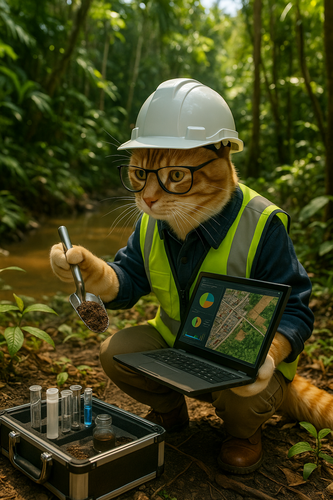

# Instalar e importar librerías y Autenticar e inicializar Earth Engine

In [9]:

!pip install earthengine-api geemap
import ee
import geemap
from geemap import colormaps as cm
import re

ee.Authenticate()
ee.Initialize(project='eddycc66')

# Desarrollo del Proceso

In [13]:
# =======================
# 1. PARÁMETROS INICIALES
# =======================
area_estudio = ee.FeatureCollection("projects/eddycc66/assets/areadesmonte")
geometry = area_estudio.geometry()
fecha_inicio = '2020-01-01'
fecha_fin = '2021-01-01'

# =======================
# 2. FACTORES DE USLE
# =======================

# Sentinel-2 para NDVI
def calcular_ndvi(img):
    return img.normalizedDifference(['B8', 'B4']).rename('NDVI')

sentinel2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(geometry)
    .filterDate(fecha_inicio, fecha_fin)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(calcular_ndvi)
    .median()
    .clip(geometry))

ndvi = sentinel2.select('NDVI')

# Factor R (precipitación CHIRPS)
precipitacion = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
    .filterDate(fecha_inicio, fecha_fin)
    .sum()
    .clip(geometry))

factor_R = precipitacion.rename("R")

# Factor K (OpenLandMap, reescalado para valores aproximados)
textura_suelo = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02").select("b0").clip(geometry)
factor_K = textura_suelo.divide(100).rename("K")

# Factor LS (SRTM)
srtm = ee.Image("USGS/SRTMGL1_003").clip(geometry)
pendiente = ee.Terrain.slope(srtm)
flow_acc = srtm.unitScale(0, 1000).multiply(100)
factor_LS = flow_acc.multiply(pendiente.divide(100)).sqrt().rename("LS")

# Factor C (NDVI invertido como cobertura)
factor_C = ndvi.multiply(-1).add(1).rename("C")

# Factor P (constante)
factor_P = ee.Image.constant(0.6).clip(geometry).rename("P")

# =======================
# 3. CÁLCULO DE EROSIÓN
# =======================
erosion_usle = factor_R.multiply(factor_K).multiply(factor_LS).multiply(factor_C).multiply(factor_P).rename('EROSION').clip(geometry)

# =======================
# 4. CLASIFICAR EROSIÓN Y CALCULAR ÁREAS
# =======================
clases = ee.List([
    ee.Dictionary({'nombre': 'Leve', 'min': 0, 'max': 10}),
    ee.Dictionary({'nombre': 'Moderada', 'min': 10, 'max': 50}),
    ee.Dictionary({'nombre': 'Severa', 'min': 50, 'max': 1e6})
])

def clasificar_por_clase(img, clases):
    def clasificar_clase(clase):
        clase = ee.Dictionary(clase)
        nombre = clase.getString('nombre')
        min_val = clase.getNumber('min')
        max_val = clase.getNumber('max')
        mask = img.gte(min_val).And(img.lt(max_val))
        clase_img = mask.updateMask(mask).rename(nombre)
        return clase_img
    clases_img = clases.map(clasificar_clase)
    return ee.ImageCollection(clases_img).toBands()

usle_clasificado = clasificar_por_clase(erosion_usle, clases)

pixel_area = ee.Image.pixelArea().divide(10000)  # m2 a ha

def seleccionar_banda_por_nombre(img, nombre):
    bandas = img.bandNames().getInfo()
    banda_encontrada = [b for b in bandas if re.search(f'_{nombre}$', b)]
    if banda_encontrada:
        return img.select(banda_encontrada[0])
    else:
        raise ValueError(f"Banda con nombre terminado en _{nombre} no encontrada")

def calcular_area(clase_nombre):
    clase_img = seleccionar_banda_por_nombre(usle_clasificado, clase_nombre)
    area_dict = clase_img.multiply(pixel_area).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,
        maxPixels=1e13
    )
    valores = area_dict.values()
    area_ha = valores.get(0)
    return area_ha

area_leve = calcular_area('Leve').getInfo()
area_moderada = calcular_area('Moderada').getInfo()
area_severa = calcular_area('Severa').getInfo()

print(f"Área afectada por erosión leve (ha): {area_leve:.2f}")
print(f"Área afectada por erosión moderada (ha): {area_moderada:.2f}")
print(f"Área afectada por erosión severa (ha): {area_severa:.2f}")

# =======================
# 5. VISUALIZACIÓN
# =======================
Mapa = geemap.Map(center=[-17.5, -66.1], zoom=9)
Mapa.addLayer(area_estudio, {}, "Área de Estudio")

# Añadir factores con paletas solicitadas
Mapa.addLayer(factor_R, {"min": 0, "max": 2000, "palette": ["white", "blue"]}, "Factor R")
Mapa.addLayer(factor_K, {"min": 0, "max": 1, "palette": ["white", "brown"]}, "Factor K")
Mapa.addLayer(factor_LS, {"min": 0, "max": 10, "palette": ["white", "orange"]}, "Factor LS")
Mapa.addLayer(factor_C, {"min": 0, "max": 1, "palette": ["green", "yellow"]}, "Factor C")
Mapa.addLayer(erosion_usle, {"min": 0, "max": 200, "palette": ["white", "red"]}, "USLE (Erosión)")

Mapa.addLayerControl()
Mapa


Área afectada por erosión leve (ha): 498.40
Área afectada por erosión moderada (ha): 8904.60
Área afectada por erosión severa (ha): 90.73


Map(center=[-17.5, -66.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Exportar Resultados al drive

In [14]:
# =======================
# 6. EXPORTAR RESULTADO A GEO DRIVE
# =======================
def exportar_a_drive(imagen, nombre, region, escala=30, carpeta='GEE_USLE'):
    task = ee.batch.Export.image.toDrive(
        image=imagen.clip(region),
        description=nombre,
        folder=carpeta,
        fileNamePrefix=nombre,
        region=region.bounds().getInfo()['coordinates'],
        scale=escala,
        maxPixels=1e13
    )
    task.start()
    print(f"✅ Exportación iniciada: {nombre}")

# Exportar subproductos
exportar_a_drive(factor_R, 'Factor_R', geometry)
exportar_a_drive(factor_K, 'Factor_K', geometry)
exportar_a_drive(factor_LS, 'Factor_LS', geometry)
exportar_a_drive(factor_C, 'Factor_C', geometry)
exportar_a_drive(factor_P, 'Factor_P', geometry)
# Exportar producto final USLE
exportar_a_drive(erosion_usle, 'USLE_Erosion', geometry)

✅ Exportación iniciada: Factor_R
✅ Exportación iniciada: Factor_K
✅ Exportación iniciada: Factor_LS
✅ Exportación iniciada: Factor_C
✅ Exportación iniciada: Factor_P
✅ Exportación iniciada: USLE_Erosion
